In [ ]:
# Step 1: Mount Google Drive and unzip CelebA dataset
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

zip_path ="/content/drive/MyDrive/archive (16).zip"
extract_path = "/content/Dataset/MildDemented"  # Destination folder

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction completed!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Extraction completed!


In [ ]:
pip install tensorflow

In [ ]:
# Step 2: Load the Trained Teacher Model
import tensorflow as tf
from tensorflow.keras.models import load_model

# Custom SSIM-based loss and metric (used in the teacher model)
def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def combined_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    ssim_val = tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return 0.5 * mse + 0.5 * (1 - ssim_val)

# Load the teacher model
teacher_model = load_model(
    '/content/drive/MyDrive/TeacherModelalz/teacher_unet_alz.h5',
    custom_objects={'combined_loss': combined_loss, 'ssim_metric': ssim_metric}
)

print("✅ Teacher model loaded successfully!")

✅ Teacher model loaded successfully!


In [ ]:
!pip install opencv-python

In [ ]:
import shutil

# ⚠️ WARNING: This deletes all existing blurred images
if os.path.exists(blurry_folder):
    shutil.rmtree(blurry_folder)

os.makedirs(blurry_folder, exist_ok=True)


In [ ]:
import cv2
import numpy as np
import random
from tqdm import tqdm

# Define folders again
sharp_folder = os.path.join(extract_path, "Dataset", "MildDemented")
blurry_folder = os.path.join(extract_path, "blurry")

# Make blurry folder if not exists
os.makedirs(blurry_folder, exist_ok=True)

# Apply Gaussian or Motion Blur randomly
def apply_motion_blur(image, kernel_size=9):
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    kernel /= kernel_size
    return cv2.filter2D(image, -1, kernel)

def apply_random_blur(image):
    if random.choice(['gaussian', 'motion']) == 'gaussian':
        return cv2.GaussianBlur(image, (9, 9), sigmaX=random.uniform(0.5, 1.5))
    else:
        return apply_motion_blur(image)

# Generate blurred images
def create_blurry_images(src_folder, dest_folder, limit=18000, img_size=(128, 128)):
    count = 0
    files = [f for f in os.listdir(src_folder) if f.endswith('.jpg')]
    random.shuffle(files)

    for filename in tqdm(files, desc="Generating blurry images"):
        img_path = os.path.join(src_folder, filename)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, img_size)
        blurred = apply_random_blur(img)
        cv2.imwrite(os.path.join(dest_folder, filename), blurred)
        count += 1
        if count >= limit:
            break

# Run it
create_blurry_images(sharp_folder, blurry_folder)
print("✅ Blurry images created.")

Generating blurry images: 100%|██████████| 2000/2000 [00:01<00:00, 1263.59it/s]

✅ Blurry images created.


In [ ]:
from sklearn.model_selection import train_test_split
import os

# Step 1: Set paths
sharp_folder = os.path.join(extract_path, "Dataset", "MildDemented")
blurry_folder = os.path.join(extract_path, "blurry")

# Step 2: ONLY use the blurred images (you created 8000)
blurred_files = sorted([f for f in os.listdir(blurry_folder) if f.endswith('.jpg')])

# 💡 Optional sanity check
print("Found blurred images:", len(blurred_files))  # Should print 8000

# Step 3: Now split ONLY those
train_files, val_files = train_test_split(blurred_files, test_size=0.2, random_state=42)

print(f"✅ Train: {len(train_files)} | Val: {len(val_files)}")


Found blurred images: 2000
✅ Train: 1600 | Val: 400


In [ ]:
# 3.2: Create Data Generator for KD (Blurry → [GT, Teacher Output])
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

class KDImagePairGenerator(Sequence):
    def __init__(self, blurry_dir, sharp_dir, filenames, teacher_model, batch_size=16, img_size=(128, 128), shuffle=True):
        self.blurry_dir = blurry_dir
        self.sharp_dir = sharp_dir
        self.filenames = filenames
        self.teacher_model = teacher_model
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.filenames) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.filenames)

    def __getitem__(self, idx):
        batch_files = self.filenames[idx * self.batch_size : (idx + 1) * self.batch_size]
        x_blur, y_true, y_teacher = [], [], []

        for f in batch_files:
            try:
                blur_path = os.path.join(self.blurry_dir, f)
                sharp_path = os.path.join(self.sharp_dir, f)

                blur_img = img_to_array(load_img(blur_path, target_size=self.img_size)) / 255.0
                sharp_img = img_to_array(load_img(sharp_path, target_size=self.img_size)) / 255.0

                x_blur.append(blur_img)
                y_true.append(sharp_img)
            except Exception as e:
                print(f"Error loading {f}: {e}")
                continue

        x_blur = np.array(x_blur, dtype=np.float32)
        y_true = np.array(y_true, dtype=np.float32)
        y_teacher = self.teacher_model.predict(x_blur, verbose=0)

        # ✅ Concatenate along the channel axis
        combined_target = np.concatenate([y_true, y_teacher], axis=-1)
        return x_blur, tf.convert_to_tensor(combined_target, dtype=tf.float32)



In [ ]:
# 3.3: Initialize Generators
# Create student training and validation generators
train_kd_gen = KDImagePairGenerator(blurry_folder, sharp_folder, train_files, teacher_model, batch_size=32)
val_kd_gen = KDImagePairGenerator(blurry_folder, sharp_folder, val_files, teacher_model, batch_size=32)

print("✅ KD generators ready.")

✅ KD generators ready.


In [ ]:
from tensorflow.keras import layers, Model
def build_student_model(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder 1
    x = layers.Conv2D(32, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, padding='same')(x)  # extra layer
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Encoder 2
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    # Encoder 3 (Extra layer)
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Bottleneck
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.1)(x)  # Optional

    # Decoder 1
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Decoder 2
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Final Output Layer
    outputs = layers.Conv2D(3, 1, activation='sigmoid')(x)

    return Model(inputs, outputs, name="ImprovedStudentModel")


In [ ]:
student_model = build_student_model()
student_model.summary()

Model: "ImprovedStudentModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 344,355 (1.31 MB)

 Trainable params: 343,395 (1.31 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Step 5: Define the Knowledge Distillation (KD) Loss & Compile the Student Model

# 5.1: Define Custom KD Loss in TensorFlow
import tensorflow as tf
from tensorflow.keras.losses import Loss

class KDLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.7, beta=0.3, name="kd_loss"):
        super().__init__(name=name)
        self.alpha = alpha
        self.beta = beta

    def call(self, y_true_combined, y_pred):
        y_true_gt = y_true_combined[..., :3]
        y_teacher = y_true_combined[..., 3:]

        mse_teacher = tf.reduce_mean(tf.square(y_pred - y_teacher))
        mse_gt = tf.reduce_mean(tf.square(y_pred - y_true_gt))
        return self.alpha * mse_teacher + self.beta * mse_gt


In [ ]:
# 5.2: Compile the Student Model
from tensorflow.keras.optimizers import Adam

student_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=KDLoss(alpha=0.7, beta=0.3)
)

print("✅ Student model compiled with KD loss.")

✅ Student model compiled with KD loss.


In [ ]:
import os

# Define the full path
save_dir = "/content/drive/MyDrive/StudentModel_alz"

# Create the folder if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Define the final path to save the model
model_path = os.path.join(save_dir, "student_model_alz_kd.h5")


In [ ]:
# Step 6: Train the Student Model Using KD

# 6.1: Set Up Callbacks
from tensorflow.keras import callbacks

# Stop training if no improvement
early_stop = callbacks.EarlyStopping(
    monitor='val_ssim',
    mode='max',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    "/content/StudentModel_alz/student_model_alz_kd.h5",
    monitor='val_ssim',
    mode='max',
    save_best_only=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_ssim',
    mode='max',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)


In [ ]:
history = student_model.fit(
    train_kd_gen,
    validation_data=val_kd_gen,
    epochs=50,
    steps_per_epoch=len(train_kd_gen),
    validation_steps=len(val_kd_gen),
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 293ms/step - loss: 0.0496 - val_loss: 0.0731 - learning_rate: 0.0010
Epoch 2/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_ssim` which is not available. Available metrics are: loss,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_ssim` which is not available. Available metrics are: loss,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_ssim available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 225ms/step - loss: 0.0067 - val_loss: 0.0473 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - loss: 0.0048 - val_loss: 0.0372 - learning_rate: 0.0010
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 279ms/step - loss: 0.0038 - val_loss: 0.0309 - learning_rate: 0.0010
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 229ms/step - loss: 0.0035 - val_loss: 0.0240 - learning_rate: 0.0010
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - loss: 0.0032 - val_loss: 0.0204 - learning_rate: 0.0010
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - loss: 0.0030 - val_loss: 0.0192 - learning_rate: 0.0010
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - loss: 0.0030 - val_loss: 0.0129 - learning_rate: 0.0010
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - loss: 0.0027 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - loss: 0.0027 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 11/50

In [ ]:
from skimage.metrics import structural_similarity as ssim


In [ ]:
student_model.save("/content/drive/MyDrive/StudentModel_alz/final_model.h5")


In [ ]:
def evaluate_model(model, data_gen, num_batches=10):
    total_ssim = 0.0
    total_mae = 0.0
    count = 0

    for batch_index in range(num_batches):
        x_batch, y_combined = data_gen[batch_index]
        y_true_batch = y_combined[..., :3]  # Extract only the ground truth sharp image

        preds = model.predict(x_batch, verbose=0)

        for pred_img, true_img in zip(preds, y_true_batch):
            pred_gray = tf.image.rgb_to_grayscale(pred_img).numpy().squeeze()
            true_gray = tf.image.rgb_to_grayscale(true_img).numpy().squeeze()

            score = ssim(pred_gray, true_gray, data_range=1.0)
            total_ssim += score

            mae = np.mean(np.abs(pred_img - true_img))
            total_mae += mae
            count += 1

    avg_ssim = total_ssim / count
    avg_mae = total_mae / count
    return avg_ssim, avg_mae


In [ ]:
student_ssim, student_mae = evaluate_model(student_model, val_kd_gen)
print(f"📘 Student Model → SSIM: {student_ssim:.4f}, MAE: {student_mae:.4f}")

teacher_ssim, teacher_mae = evaluate_model(teacher_model, val_kd_gen)
print(f"📗 Teacher Model → SSIM: {teacher_ssim:.4f}, MAE: {teacher_mae:.4f}")


📘 Student Model → SSIM: 0.9205, MAE: 0.0308
📗 Teacher Model → SSIM: 0.9713, MAE: 0.0163


In [ ]:
# Evaluate Student Model
student_ssim, student_mae = evaluate_model(student_model, val_kd_gen)
print(f"📘 Student Model → SSIM: {student_ssim:.4f}, MAE: {student_mae:.4f}")

# Evaluate Teacher Model
teacher_ssim, teacher_mae = evaluate_model(teacher_model, val_kd_gen)
print(f"📗 Teacher Model → SSIM: {teacher_ssim:.4f}, MAE: {teacher_mae:.4f}")

📘 Student Model → SSIM: 0.9205, MAE: 0.0308
📗 Teacher Model → SSIM: 0.9713, MAE: 0.0163


In [ ]:
# 7.2: Visual Comparison (Blurry | Student | Sharp | Teacher)
import cv2
import matplotlib.pyplot as plt

def visualize_student_vs_teacher(index=0):
    filename = val_files[index]

    # Load blurry and sharp
    blurry_path = os.path.join(blurry_folder, filename)
    sharp_path = os.path.join(sharp_folder, filename)

    blur = cv2.imread(blurry_path)
    sharp = cv2.imread(sharp_path)

    if blur is None or sharp is None:
        print("Error loading images.")
        return

    blur = cv2.resize(blur, (128, 128))
    sharp = cv2.resize(sharp, (128, 128))

    input_img = np.expand_dims(blur.astype("float32") / 255.0, axis=0)

    # Predict
    student_pred = student_model.predict(input_img, verbose=0)[0]
    teacher_pred = teacher_model.predict(input_img, verbose=0)[0]

    student_pred = (student_pred * 255).astype("uint8")
    teacher_pred = (teacher_pred * 255).astype("uint8")

    # Plot
    titles = ["Blurry Input", "Student Output", "Sharp Ground Truth", "Teacher Output"]
    images = [blur, student_pred, sharp, teacher_pred]

    plt.figure(figsize=(12, 3))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

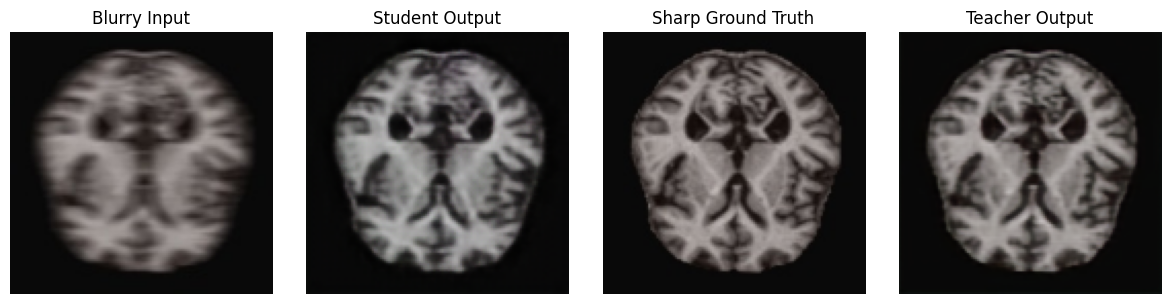

In [ ]:
visualize_student_vs_teacher(index=5)

To resolve the error, you need to modify your data generator (`train_kd_gen` and `val_kd_gen`) to yield the input image and a combined target tensor containing both the ground truth and the teacher's output. This combined target will be passed as `y_true` to the `KDLoss` function.

Here's a conceptual example of how your data generator's `__getitem__` method should be structured:

In [ ]:
# Conceptual Example of Data Generator __getitem__

# Assume you have already loaded and preprocessed blurry_image and sharp_image
# Assume you have the teacher_model available

# Get the teacher's output for the current blurry image
# Ensure blurry_image is in the correct shape and format for the teacher model
# For example, if teacher_model expects a batch:
# blurry_input_batch = np.expand_dims(blurry_image, axis=0)
# teacher_output = teacher_model.predict(blurry_input_batch)[0]

# Combine ground truth and teacher output
# combined_target = tf.concat([sharp_image, teacher_output], axis=-1)

# Yield the input image and the combined target
# return blurry_image, combined_target

print("✅ Data generator modification concept shown.")

✅ Data generator modification concept shown.


Once you have updated your data generators, you can re-run the training cell.